# Project 3

<font size = 3>
In this project we use four different numerical methods to solve ordinary differential equations.
These methods are the Shampine-Bogacki method, Runge-Kuttas method of 4th order, Kahans method and the Störmer-Verlet method. The system we will use these methods on is the Hénon-Heiles system consisting of the equations given on page 1 in the handout $[8]$, given that lambda is set to be 1.


Comparing the four methods we will verify and estimate the rate of convergence for the global error, examine the conservation of energy and calculate the Poincaré cuts with the given inital conditions. Having these properties in mind we will try to conclude which of the methods is best to use.


We have not taken into account the possibility of explicit dependecy of time in this project. We will often refer to equations and figures from the handout $[8]$.
<font>


-------------

In [15]:
# Importing required libraries. 
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
from scipy import linalg

In [16]:
# Importing numba and jit to increase speed of code. 
%pip install numba
%pip install numba-scipy
from numba import jit, uint64

# Supressing Deprecation warnings
from numba.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


-------------

# Hénon-Heiles model

The Hénon-Heiles model uses a simplified two-dimensional nonlinear axi-symmetric potential and has the following Hamiltonian expression

$H(q,p) = T(p) + V(q)$, where

$T(p) = \small\frac{1}{2}(p_1^2 + p_2^2)  $   and   $V(q) = \small\frac{1}{2}(q_1^2 + q_2^2) + \lambda(q_1^2q_2 - \small\frac{1}{3}q_2^3)$.

The system is then defined by the four equations


$
q_1' = p_1 \\
q_2' = p_2 \\
p_1' = -q_1(1+2\lambda q_2) \\
p_2' = -q_2 - \lambda (q_1^2-q_2^2)
$

where q represents position, p impulse and we set $\lambda$ to be 1.


In [17]:
# Function to derivate (q1, q2, p1, p2) in accordance with the Hénon-Heiles model given on page 1 [8].
@jit(nopython = True) # Using jit so the function will run faster.
def H(t,y):
    d_q1 = y[2]
    d_q2 = y[3]
    d_p1 = - y[0]*(1 + 2*y[1])
    d_p2 = - (y[1] + y[0]**2 - y[1]**2)
    return np.array([d_q1, d_q2, d_p1, d_p2])


## Initial values

In [18]:
# Calculates p_1 from the given initial values and the Eq found on page 6 [8].
@jit(nopython = True) 
def Initial_Values(q_1, q_2, p_2, lamb, H_value):
    p_1 = np.sqrt(2*H_value-q_1**2-q_2**2-p_2**2-2*lamb*(q_1**2*q_2-(1/3)*q_2**3)) # Solve the Eq. for p_1.
    return p_1

p_1 = Initial_Values(0, 0.45, 0, 1, 1/12)
y_0 = np.array([0, 0.45, p_1, 0]) # The initial value array.

# Numerical Methods

## Shampine-Bogacki

The Shampine-Bogacki method is a Runge-Kutta method of order three with four stages that all use the First Same As Last (FSAL) property. It was proposed by Przemysław Bogacki and Lawrence F. Shampine in 1989. $[9]$

In [19]:
# Function that returns results of the Shampine-Bokacki method as a matrix. 
@jit(nopython = True)
def Shampine_Bogacki(y_0, h , t_0, T):
    n = np.arange(t_0,T+h,h) # Creates an array containing all time elements.
    n[-1] = T                # Takes into account that the last element may not be a multiple of h.
    N = len(n)               # Number of timesteps.

    y_vec = np.zeros((N, 4)) # Empty matrix to hold the results for q_1, q_2, p_1 and p_2. 
    y_vec[0,:] = y_0         # Inserts the initial values.
    F_vec = np.zeros((4,3))  # Creates an empty array 
    

    for i in range(N-1):     # Iterates through time.

        h = n[i+1]-n[i]      # Takes into account that the last timestep can be shorter.

        # Calculates the next timestep from the equations in 2.1 [8].
        F1 = H(0, y_vec[i,:])
        F2 = H(0, y_vec[i,:] + (1/2)*h*F1)
        F3 = H(0,y_vec[i,:] + (3/4)*h*F2)
        
        y_vec[i+1,:] = y_vec[i,:] + h*((2/9)*F1 + (1/3)*F2 + (4/9)*F3) 

    return y_vec

## Runge-Kutta 

The Runge-Kutta method of forth order(RK4) is the most known method in the Runge-Kutta family. It is implicit and calculates the next step using a weighted average of four increments.

In [20]:
# Function that returns results of the Runge-Kutta method as a matrix. 
@jit(nopython = True)
def Runge_Kutta(y_0, h, t_0, T):
    # Takes into account the last element.
    n = np.arange(t_0,T+h,h)
    n[-1] = T
    N = len(n)
    
    y_vec = np.zeros((N, 4)) # Matrix to hold results.
    y_vec[0,:] = y_0         # Inserts the initial values. 

    for i in range(N-1):
        h = n[i+1]-n[i]      # For the last timestep.

        # Calculates the next timestep from the equations in 2.2 [8].
        F1 = H(0, y_vec[i, :])
        F2 = H(0, y_vec[i, :] + (h/2)*F1)
        F3 = H(0, y_vec[i, :] + (h/2)*F2)
        F4 = H(0, y_vec[i, :] + h*F3)

        y_vec[i+1,:] = y_vec[i,:] + h*(1.0/6.0)*(F1 + 2*F2 + 2*F3 + F4)

    return y_vec

## Kahans 

Kahans method was created by William Kahan in the 1980s and is defined for differential equations that has a quadratic right hand side. By using Kahans method we will calculate the matrix corresponding to the Henon-Heiles system. We do this to solve the linear equation $ Ax = b $ and with Kahans method solve for the next timestep x. To do this we must create the different equations in discretezised component form using Kahans method and the Hénon-Heiles equations.


From kahans method we get  $ \Large{\frac{q_{1,(n+1)} - q_{1,(n)}}{h}  = \frac{p_{1,(n+1)} + p_{1,(n)}}{2} } $.

If we rearrange this we get our first equation  $ \large{ q_{1,n+1} - \frac{h p_{1,n+1}}{2} = \frac{h p_{1,n}}{2}+  q_{1,n}}$.

The second equation is identical except with $q_2' $ and $p_2$ , which gives us  $ \large{q_{2,n+1} - \frac{h p_{2,n+1}}{2} = \frac{h p_{2,n}}{2}  + q_{2,n}}$.

To get the third equation we first use  ${ p_1' = -2q_2q_1 -q_1 }$ 

with kahans method, and get $\large{\frac{p_{1,(n+1)} - p_{1,(n)}}{h} = -2 \frac{q_{2,n}q_{1,n+1} +q_{2,n+1}q_{1,n} }{2} - \frac{q_{1,n+1} + q_{1,n}}{2}}$.

From this we get the third equation $ p_{1,(n+1)}  +  (h q_{2,n} + \frac{h}{2})q_{1,n+1}  + (h q_{1,n})q_{2,n+1} = p_{1,n} - \frac{h q_{1,n}}{2} $




Now we do the same for the last equation with $p_2' = -(q_2 + q_1^2-q_2^2 ) $.

With kahans method we get $\frac{p_{2,(n+1)} - p_{2,(n)}}{h}  = q_{2,n+1}q_{2,n} - q_{1,n+1}q_{1,n} - \frac{q_{2,n+1}+q_{2,n}}{2}$.

If we rearrange this, we get $p_{2,(n+1)} + (hq_{1,n})q_{1,n+1} + (\frac{h}{2} -hq_{2,n}) q_{2,n+1} = p_{2,n} - \frac{h q_{2,n}}{2}$.

Putting this all together we get $Ax = b$, with



$ A = 
\begin{pmatrix}
1 & 0 & -\frac{h}{2} & 0\\
0 & 1 & 0 & -\frac{h}{2} \\
{h q_{2,n} + \frac{h}{2}} & hq_{1,n} & 1 & 0 \\
hq_{1,n} & {\frac{h}{2} -hq_{2,n}} & 0 & 1 \\ 
\end{pmatrix} 
$ and
$ b = 
\begin{bmatrix}
\frac{h p_{1,n}}{2}  + q_{1,n}\\
\frac{h p_{2,n}}{2}  + q_{2,n}\\
p_{1,n} - \frac{h q_{1,n}}{2} \\
p_{2,n} - \frac{h q_{2,n}}{2}\\
\end{bmatrix}
$

In [21]:
# Function that returns results of the Kahans method as a matrix. 
@jit(nopython = True)
def Kahans(y,h,t_0,T):

    n = np.arange(t_0,T+h,h) 
    n[-1] = T                
    N = len(n)

    y1 = np.zeros((N,4))     # Empty matrix. 
    a = np.zeros((4,4))      # Fills a 4x4 matrix with zeros.

    # Begin creating the matrix above.
    for i in range(4):
            a[i,i] = 1 
   
    # Fills first column with initial values. Does this here because of the step length. 
    y1[0,0] = y[0]
    y1[0,1] = y[1]
    y1[0,2] = y[2]
    y1[0,3] = y[3]
    
    j = 1
    while j < N:
        h = n[j] - n[j-1]    # Same as before.
        
        # Creates b in the equation Ax = b with values from above. 
        y_temp = np.zeros(4) 
        y_temp[0] = h/2*y[2]+y[0]
        y_temp[1] = h/2*y[3]+y[1]
        y_temp[2] = y[2]-h/2*y[0]
        y_temp[3] = y[3]-h/2*y[1]

        # Creates the rest of A.
        a[0,2] = -h/2
        a[1,3] = -h/2 
        a[2,0] = h*y[1]+h/2
        a[2,1] = h*y[0]
        a[3,1] = -h*y[1]+h/2
        a[3,0] = h*y[0]

        # Solves the equation Ax = b. 
        x = np.linalg.solve(a,y_temp)

        # Adding and redefining y1 matrix and "initial condition". 
        y = x
        y1[j,:]=x
        j += 1
        
    return y1


## Störmer-Verlet

The Störmer-Verlet method is made for systems of second order on the form $ q{''} = f(q)$ which we can see applies for the Hénon-Heiles system if we rewrite it to a first order system. This method is also an implicit numerical method, but stands out by using half timesteps for each $p$ value for calculating the next $q$ value and the following $p$ value.

In [22]:
# Function that returns results of the Störmer-Verlet method as a matrix. 
@jit(nopython = True)
def Störmer_Verlet(y_0, h, t_0, T):
    
    # Same as before.
    n = np.arange(t_0,T+h,h)
    n[-1] = T
    N = len(n)

    y_vec = np.zeros((N , 4))  # Matrix to hold results.
    y_vec[0,:] = y_0           # Inserts the initial values.
    
    # Iterates trough N timesteps. 
    for i in range(N-1):
        h = n[i+1] - n[i]      # Takes the last timestep into account.

        func1_1 = H(0,y_vec[i,:])
        
        # Calculations as seen in 2.4 in handout [8]. 
        p_1_1 = y_vec[i, 2] + 1/2*h *func1_1[2]  # p_n+1/2 for p1.
        p_2_1 = y_vec[i, 3] + 1/2*h *func1_1[3]  # p_n+1/2 for p2.

        y_vec[i+1,0] = y_vec[i, 0] + h*p_1_1     # Updatet q1.
        y_vec[i+1,1] = y_vec[i, 1] + h*p_2_1     # Updatet q2. 

        temp_vec = np.array([y_vec[i+1,0],y_vec[i+1,1],p_1_1,p_2_1])
        func1_2 = H(0,temp_vec[:])
        
        # New p_n+1 values for p1 and p2. 
        y_vec[i+1, 2] = p_1_1 + 1/2*h*func1_2[2]
        y_vec[i+1, 3] = p_2_1 + 1/2*h*func1_2[3]

    return y_vec

# Problem 1

We will in this problem estimate and verify the rate of convergence, ROC, for the global error in our numerical methods. We do this by using scipy's Runge-Kutta 45 method with a very small tolerance. This then works as our referance when we calculate the error for each timestep. Further on we estimate the ROC by using reasonable timestep boundaries.

## Rate of convergence

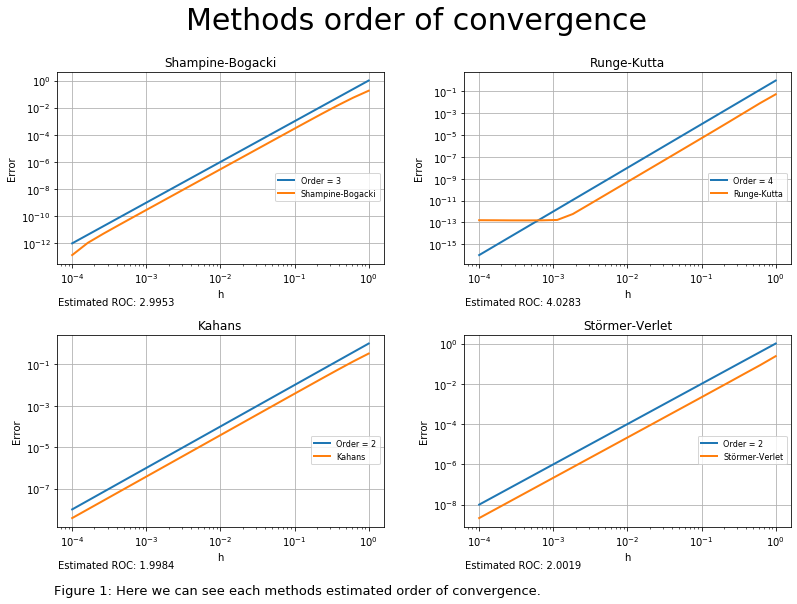

In [23]:
# Function designed to estimate rate of convergence. 
@jit(nopython = True)
def Estimate_ROC(h_vec, errors, r, s):
    # Defining list to hold values. 
    new_h_vec = []
    new_errors = []
    # We want to use a smaller range of h-steps to more accurately estimate the ROC,
    # Hence the if statment. The ranges is estimated from looking at the graphs. 
    for i in range(len(h_vec)):
        # Appends desired values.
        if (h_vec[i] > 10**(r)) and (h_vec[i] < 10**(s)):
            new_h_vec.append(h_vec[i])
            new_errors.append(errors[i])

    estimated_order = 0
    # Calculates the average estimated ROC over our chosen span of h_steps.
    for i in range(len(new_errors)-1):
        estimated_order += np.log(new_errors[i+1]/new_errors[i])/np.log(new_h_vec[i+1]/new_h_vec[i])

    # len(new_errors)-1) contains -1 because we end up with -1 pairs of h_vecs. 

    return (round(estimated_order/(len(new_errors)-1),4))


# Function that calculates and plots rate of convergence. 
def Check_Convergence(methods, t_0, T, H, y_0, r, s, orders, titles, textnr):
    
    h_vec = np.logspace(r, s, 20) # Creating a log scaled x-axis. 

    fig, [[fig1, fig2], [fig3, fig4]] = plt.subplots(2, 2, figsize = (12, 8))
    fig.tight_layout(pad=5.0)
    fig_vec = [fig1, fig2, fig3, fig4]
    fig.suptitle("Methods order of convergence", size = 30, y = 1.02)
    
    # Boundaries to estimate ROC found by studying where the graphs are paralell.
    r_1 = [-3.5,-2.7,-4,-5 ] 
    s_1 = [-0.5,0,-0.5,-0.5]
    for i in range(len(methods)):

        # Our reference, which works as our estimate for the analytical equation. 
        y_ref = scipy.integrate.solve_ivp(H, (t_0, T), y_0, method='RK45', rtol = 3e-13, atol = 1e-18).y
    
        # Empty array to hold our values. 
        errors = np.zeros_like(h_vec) 

        for n in range(len(h_vec)):
            y_vec = methods[i](y_0, h_vec[n], t_0, T) # Calculated our matrix. 

            # Calculates the difference bewtween the estimated analytical integration and 
            # the measured calculated integration with different methods
            # at the last time step and calculates the size of this. 
            errors[n] = np.linalg.norm(y_ref[:,-1]-y_vec[-1,:]) 

        Estimated_ROC = Estimate_ROC(h_vec, errors,r_1[i], s_1[i] )

        # Plots each individual methods ROC in a subplot. 
        fig_vec[i].text(0.18, -0.20,f"Estimated ROC: "+ str(Estimated_ROC), horizontalalignment='center',verticalalignment='center', transform=fig_vec[i].transAxes)
        fig_vec[i].grid()
        fig_vec[i].loglog(h_vec, h_vec**orders[i], label = "Order = "+ str(orders[i]), linewidth = 2)
        fig_vec[i].loglog(h_vec,errors, linewidth = 2, label = titles[i])
        fig_vec[i].set_xlabel("h", size = 10)
        fig_vec[i].set_ylabel("Error", size = 10)
        fig_vec[i].legend(prop={"size":8}, loc = "center right", bbox_to_anchor=(0.5, -0.1, 0.5, 1))
        fig_vec[i].title.set_text(titles[i])

    fig.text(0.08, 0.00, "Figure 1: Here we can see each methods estimated order of convergence.", fontsize = 13)
    plt.show()


# Initial conditions.
y_0 =np.array(y_0)

# Inputs for function.
methods = [Shampine_Bogacki, Runge_Kutta, Kahans, Störmer_Verlet]
methods_name = ["Shampine-Bogacki", "Runge-Kutta", "Kahans", "Störmer-Verlet"]
orders = [3, 4, 2, 2]

# Calls functions.
Check_Convergence(methods, 0, 10, H, y_0, 0, -4, orders, methods_name, 0)


The ROC for the different estimates are not equal to the theoretical values due to our step length not going to zero, but they are in the same vicinity of the theoretical value for all methods. Another interesting point is the error from Runge-Kutta 4 when the error hits the critical value around $10^{-14}$ as seen in Figure 1. This shows the limit of the precision of our referance. This is why we choose new boundaries to estimate our ROC from. The plots also visualise the converengence we expect from our higher order methods where a decrease in stepsize $h$, will result in a lower error compared to the lower order methods. The decrease is also exponentially proportional to the order as we would expect. 

# Problem 2

We will in this problem examine the conservation of energy in our hamiltonian system for our methods. Furthermore we will conclude which methods are best to use with regards to steplength $h$ and timesteps $T$.

In [24]:
# Definition of Hamilton function.
@jit(nopython = True)
def Hamilton(y, lamb):
    q1, q2, p1, p2 = y[0], y[1], y[2], y[3]
    T = (1/2)*(p1**2+p2**2)                               # Kinetic energy
    V = (1/2)*(q1**2+q2**2) + lamb*(q1**2*q2-(1/3)*q2**3) # Potential energy
    return T + V                                          # Total energy

In [25]:
# Defines function that calculates energy loss for each method. 
@jit(nopython = True)
def Energy_Loss(method, t_0, T, h, y_0, lamb):
    y_array = method(y_0, h, t_0, T)      # Gets array containing all values for q and p for all timesteps.
    Energy = np.zeros(len(y_array[:,0]))  # Empty energy array. 
    total_Energy = 0                      # Value to hold the total energy.

    # Calculates energy for each timestep and adds it to the energy array and total energy.
    for i in range(len(Energy)):
        Energy[i] = Hamilton(y_array[i,:], lamb)
        total_Energy += Energy[i]

    t_array = np.linspace(t_0, T, len(Energy))  # Time array for plotting.
    average_Energy = total_Energy/(len(Energy)) # Calculates average energy.

    return t_array, Energy, average_Energy

# Function for plotting the energy compared to its energy loss. 
def Plot_Energy(T_1, T_2, T_3, E_1, E_2, E_3, AE_1, AE_2, AE_3, title, textnr):

    # A lot of code to make the plots look nice.
    fig, (fig1,fig2, fig3) = plt.subplots(3, figsize = (12, 8))
    fig.tight_layout(pad = 3.0)
    figtext = ["Figure 2",
     "Figure 3", 
     "Figure 4", 
     "Figure 5"]
    plt.figtext(0.065, 0.00, figtext[textnr], fontsize = 15, va = "top", ha = "left")

    fig1.plot(T_1, E_1, linewidth = 3, label = "Conserved energy, h = 0.1")
    fig1.plot(T_1, (1/12)*np.ones(len(T_1)),'--', label = "Initial energy", linewidth = 3)
    fig1.legend(prop={"size":12}, loc = "upper right", bbox_to_anchor=(0.5, -0.1, 0.5, 1))
    fig1.grid()
    fig.suptitle(title, size = 30, y = 1.02)

    fig2.plot(T_2, E_2, linewidth = 3, label = "Conserved energy, h = 0.01")
    fig2.plot(T_2, (1/12)*np.ones(len(T_2)),'--', label = "Initial energy", linewidth = 3)
    fig2.set_ylabel('Energy [J]', fontsize = 17)
    fig2.legend(prop={"size":12}, loc = "upper right", bbox_to_anchor=(0.5, -0.1, 0.5, 1))
    fig2.grid()
    
    fig3.plot(T_3, E_3, linewidth = 3, label = "Conserved energy, h = 0.001")
    fig3.plot(T_3, (1/12)*np.ones(len(T_3)),'--', label = "Initial energy", linewidth = 3)
    fig3.set_xlabel('Time [s]', fontsize = 17) 
    fig3.legend(prop={"size":12}, loc = "upper right", bbox_to_anchor=(0.5, -0.1, 0.5, 1))
    fig3.grid()
    
    plt.show()


    print(f'Initial E: ', (1/12))
    print(f'             Average energy')
    print(f'(h  =  0.1)'.ljust(12), str(AE_1).ljust(14))
    print(f'(h  = 0.01)'.ljust(12), str(AE_2).ljust(14))
    print(f'(h = 0.001)'.ljust(12), str(AE_3).ljust(14))

    


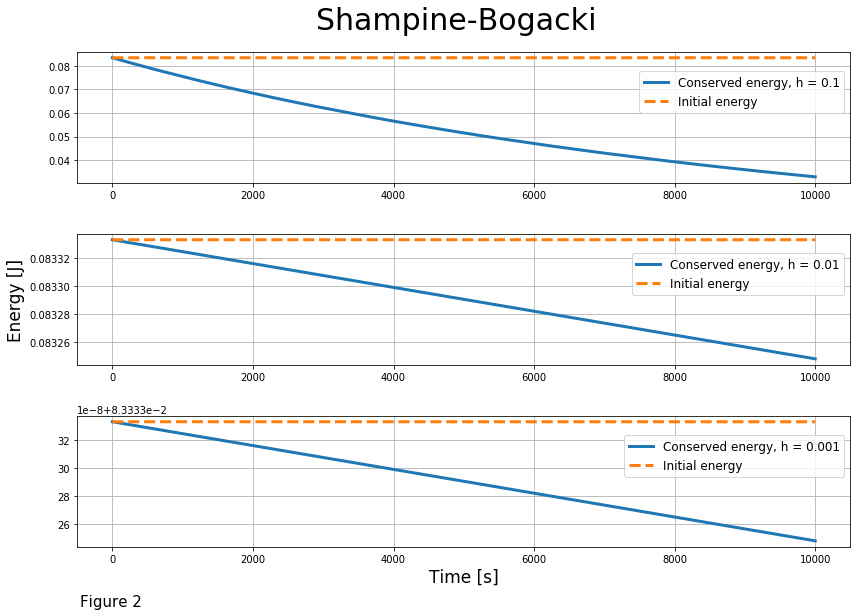

Initial E:  0.08333333333333333
             Average energy
(h  =  0.1)  0.0536918062915105
(h  = 0.01)  0.08329078621802853
(h = 0.001)  0.08333329076539396


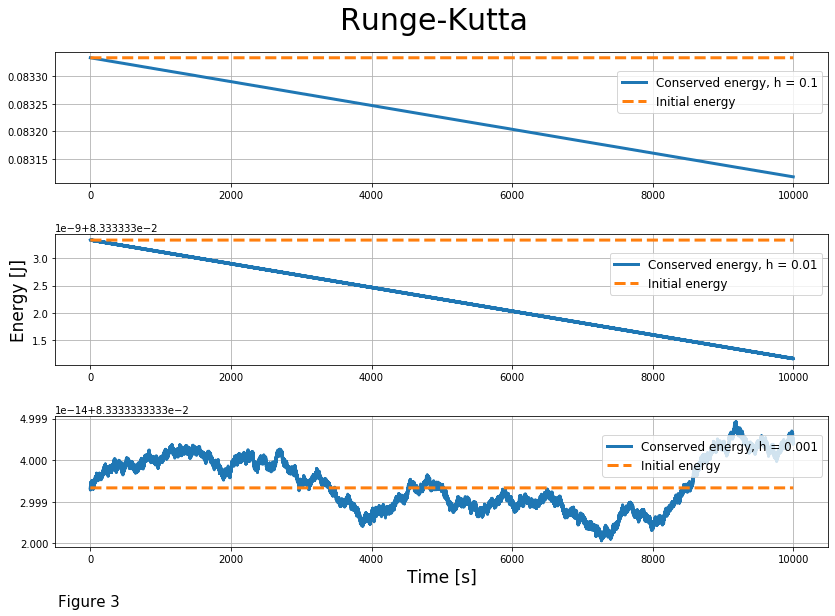

Initial E:  0.08333333333333333
             Average energy
(h  =  0.1)  0.08322513665289262
(h  = 0.01)  0.08333333224808973
(h = 0.001)  0.08333333334284156


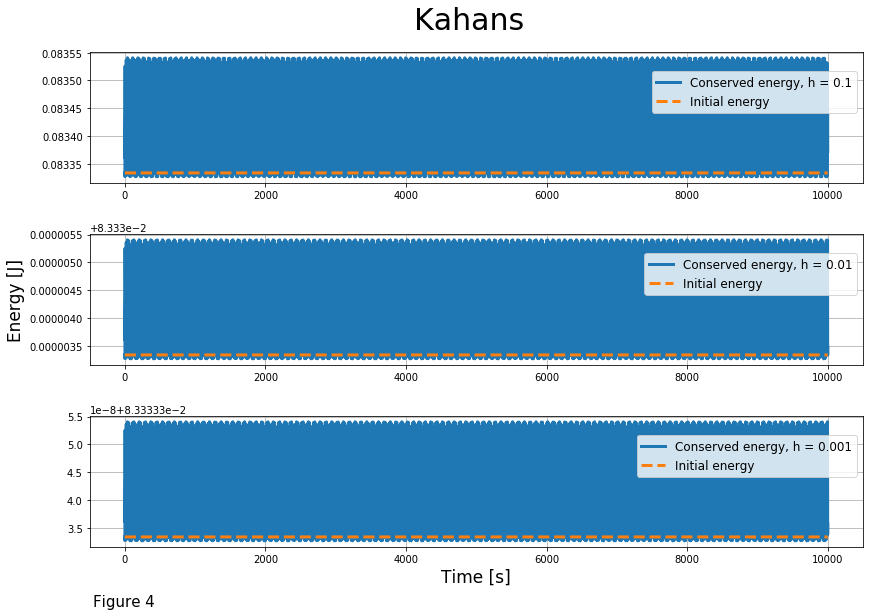

Initial E:  0.08333333333333333
             Average energy
(h  =  0.1)  0.08342499950522515
(h  = 0.01)  0.08333425002812675
(h = 0.001)  0.08333334249993442


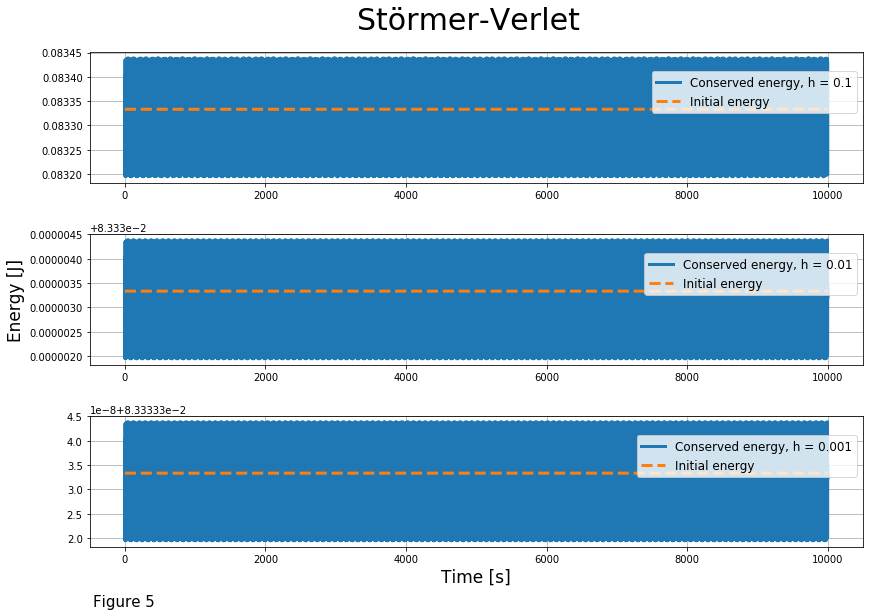

Initial E:  0.08333333333333333
             Average energy
(h  =  0.1)  0.08331337157779041
(h  = 0.01)  0.08333313178689504
(h = 0.001)  0.08333333131767422


In [26]:
# Arrays for time, energy and the average energy for all methods.
SB_T_1, SB_E_1, SB_AE_1 = Energy_Loss(Shampine_Bogacki, 0, 1e4, 0.1, y_0, 1)
SB_T_2, SB_E_2, SB_AE_2 = Energy_Loss(Shampine_Bogacki, 0, 1e4, 0.01, y_0, 1)
SB_T_3, SB_E_3, SB_AE_3 = Energy_Loss(Shampine_Bogacki, 0, 1e4, 0.001, y_0, 1)

Plot_Energy(SB_T_1, SB_T_2, SB_T_3, SB_E_1, SB_E_2, SB_E_3, SB_AE_1, SB_AE_2, SB_AE_3, "Shampine-Bogacki", 0) 
# Deletes values to make up up space in the kernel.
del SB_T_1; del SB_E_1; del SB_AE_1
del SB_T_2; del SB_E_2; del SB_AE_2
del SB_T_3; del SB_E_3; del SB_AE_3

RK_T_1, RK_E_1, RK_AE_1 = Energy_Loss(Runge_Kutta, 0, 1e4, 0.1, y_0, 1)
RK_T_2, RK_E_2, RK_AE_2 = Energy_Loss(Runge_Kutta, 0, 1e4, 0.01, y_0, 1)
RK_T_3, RK_E_3, RK_AE_3 = Energy_Loss(Runge_Kutta, 0, 1e4, 0.001, y_0, 1)

Plot_Energy(RK_T_1, RK_T_2, RK_T_3, RK_E_1, RK_E_2, RK_E_3, RK_AE_1, RK_AE_2, RK_AE_3, "Runge-Kutta", 1) 
del RK_T_1; del RK_E_1; del RK_AE_1
del RK_T_2; del RK_E_2; del RK_AE_2
del RK_T_3; del RK_E_3; del RK_AE_3

C_T_1, C_E_1, C_AE_1 = Energy_Loss(Kahans, 0, 1e4, 0.1, y_0, 1)
C_T_2, C_E_2, C_AE_2 = Energy_Loss(Kahans, 0, 1e4, 0.01, y_0, 1)
C_T_3, C_E_3, C_AE_3 = Energy_Loss(Kahans, 0, 1e4, 0.001, y_0, 1)

Plot_Energy(C_T_1, C_T_2, C_T_3, C_E_1, C_E_2, C_E_3, C_AE_1, C_AE_2, C_AE_3, "Kahans", 2) 
del C_T_1; del C_E_1; del C_AE_1
del C_T_2; del C_E_2; del C_AE_2
del C_T_3; del C_E_3; del C_AE_3

SV_T_1, SV_E_1, SV_AE_1 = Energy_Loss(Störmer_Verlet, 0, 1e4, 0.1, y_0, 1)
SV_T_2, SV_E_2, SV_AE_2 = Energy_Loss(Störmer_Verlet, 0, 1e4, 0.01, y_0, 1)
SV_T_3, SV_E_3, SV_AE_3 = Energy_Loss(Störmer_Verlet, 0, 1e4, 0.001, y_0, 1)

Plot_Energy(SV_T_1, SV_T_2, SV_T_3, SV_E_1, SV_E_2, SV_E_3, SV_AE_1, SV_AE_2, SV_AE_3, "Störmer-Verlet", 3) 
del SV_T_1; del SV_E_1; del SV_AE_1
del SV_T_2; del SV_E_2; del SV_AE_2
del SV_T_3; del SV_E_3; del SV_AE_3

From the plots we can observe that Shampine-Bogacki has a significantly higher energy loss compared to the others and its energy loss appears to be linearly related. The Runga-Kutta method which is a similar method to Shampine-Bogacki, only more accurate, also lose energy linearly, but at a much slower rate than Shampine-Bogacki. This is not the case for the h = 0.01 because the floating point precision is exceeded. Furthermore, both Störmer-Verlet and Kahans method are better at energy conserving than the Runge-Kutta family, because the error they produce are alternating between above and below the initial energy, which in long runs maintains a constant energy level significantly better than Shampine-Bogaki.

The average energy shown below the plots is a nice indicator of how accurate the methods are, even though it is nice to mention it does not directly show how good the methods are at preserving energy. The initial energy has a value of $\frac{1}{12}$ so the average energy closest to 0.08333... is the most accurate for our time period. We clearly see that the average energy of Runge-Kutta is most accurate, followed by Störmer-Verlet, Kahans and lastly Shampine-Bogacki.

The reason for the different result and behaviour occur because of the different integration methods. Störmer-Verlet has the properties of a symplectic integration method. What this means is that the method does not approximate the actual hamiltonian mechanics of the desired system, but reproduce a close shadow whose value it conserves substaniually more accurately.  The solutions to this shadow hamiltonian will, because they lie in a symplectic manifold, be periodic and therfore be very good for integration over a longer period of time. 

Kahans method maintains similar properties even though it is not a symplectic method of integration. According to $[1]$, Kahans follow in a similar path to Störmer-Verlet in that instead of following the exact hamiltonian mechanics, it creates a modified hamiltonian and an invariant measure where it conserves energy more accuratly$[1,4,5]$. The error between the real hamiltonian and the different modified hamiltonian will differ from different timesteps in the simulation. This is true for both Störmer-Verlet and Kahans and migth explain why Kahans oscillates above the initial energy and Störmer-Verlet oscillates more closely around the initial energy (due to different modified hamiltonian).  

If we look at Shampine-Bogaki and Runge-Kutta we see that they do not possess the same qualities as the two others. By comparisson we can tell that both methods lose energy but at very different rates. The loss in both method corresponds to a local error which perpetuates and builds up over time. 

For the Kutta family the error at each step is given by $\mathcal O(h^{p+1})$ where $p$ is the order of convergence and $h$ is the step lenght $[7]$ . This is a linear relation in which the system loses energy for every step, but for the alternating methods the step length and order is proportional to the max amplitude in which the error at each step oscillates. The global energy loss for the modified hamilton methods are given from theorem 8.1 in $[2]$ and are given by $\mathcal O(e^{h_o/2h})$ and not 
 $\mathcal O(h^p)$ $[7]$ as they are for the Kutta family. This means that for longer integration periods we will have significantly smaller energy loss.


A change in the stepsize $h$ will therefore give different results. For the reasons mentioned above, a lower step size will decrease the error of Runge-Kutta and is again propotional to the methods order.This is posssible to tell from the graphs by looking at the value of the y-axis for different step lengths and seeing the are proportional to $ h^p$.  The energy loss will of course be minimized for the alternating methods,but their oscillations is still bound by $h^p$ so local error will be bigger than the Kutta family.

For the choice of method it really depends on what you are searching for. It is clear that for large integrations over longer periods of time the error presented in Runge-Kutta and escpecially in Shampine-Bogacki will present a significant error and will therefore not always be sufficient. By using a symplectic method such as Störmer-Verlet or a similar method such as Kahans we can make sure the energy still is conserved over large timescales, but have a larger local error due to the fact they are of order 2. We can also note that Runge-Kutta even though it has a small error that error is almost dissmisable for medium time sizes and therefore with big enough computing power could produce great results.

So in summary the Runge-Kutta of order 4 is the best as a function of step size but as a function T the best method would be Störmer-Verlet since it conserves energy better and oscillates closer to the initial value. 

## Problem 3

Below we will calculate and plot Poincaré cuts for Hénon-Heiles using the four different methods. 

In [27]:
# Defines the Poincaré function to
@jit(nopython = True)
def Poincaré(method, t_0, T, h, y_0):

    y = method(y_0, h, t_0, T)
 
    q_2_list = []
    p_2_list = []

    # Appends the initial values since q_1 starts at 0.
    q_2_list.append(y[0,1])
    p_2_list.append(y[0,3])

    # Iterates through the y array and checks if the given conditions are present.
    for i in range(1,len(y)-1):
        # Finds the values where p1 > 0 and when q1 cosses zero. 
        if (y[i, 2]>0) and (y[i, 0]*y[i+1, 0] < 0):
            
            # Interpolation. 

            # Introduce a time parameter tau and estimates its value when q_1 = 0.
            tau = y[i,0]/(y[i,0]-y[i+1,0]) 

            # Can then interpolate using tau to find q_2 and p_2.
            q_2 = tau*y[i+1,1]+(1-tau)*y[i,1]
            p_2 = tau*y[i+1,3]+(1-tau)*y[i,3]

            # Appends values to lists. 
            q_2_list.append(q_2)
            p_2_list.append(p_2)

    return q_2_list, p_2_list

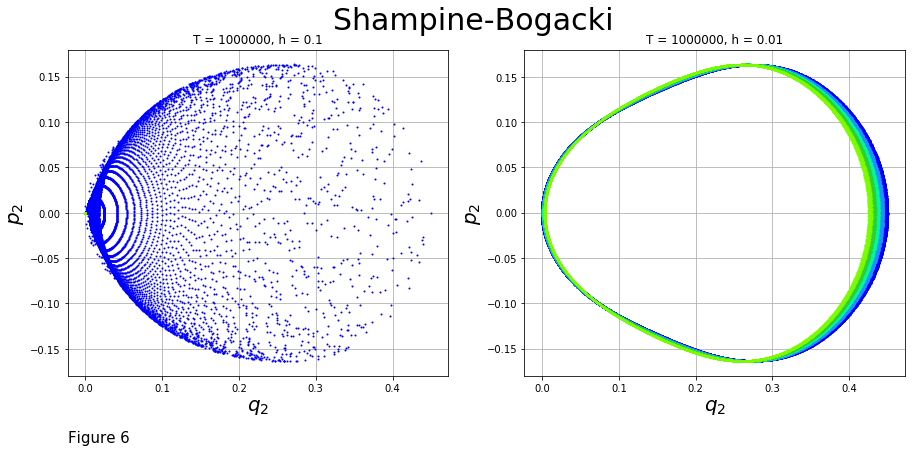

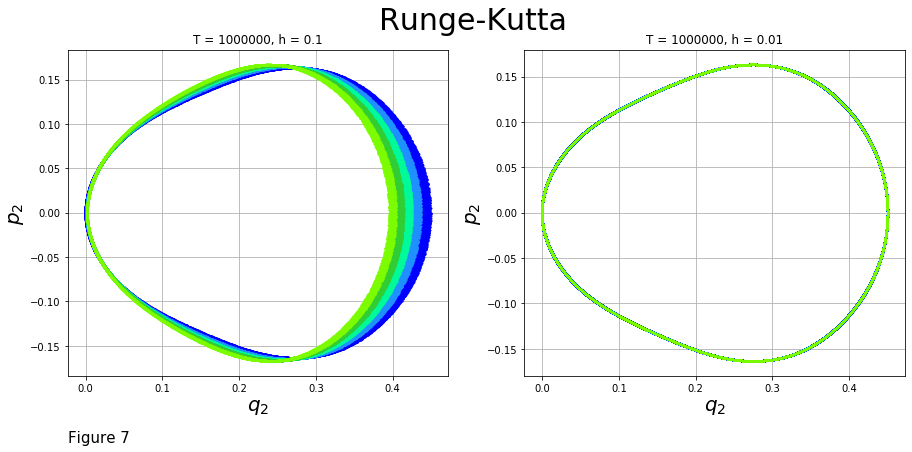

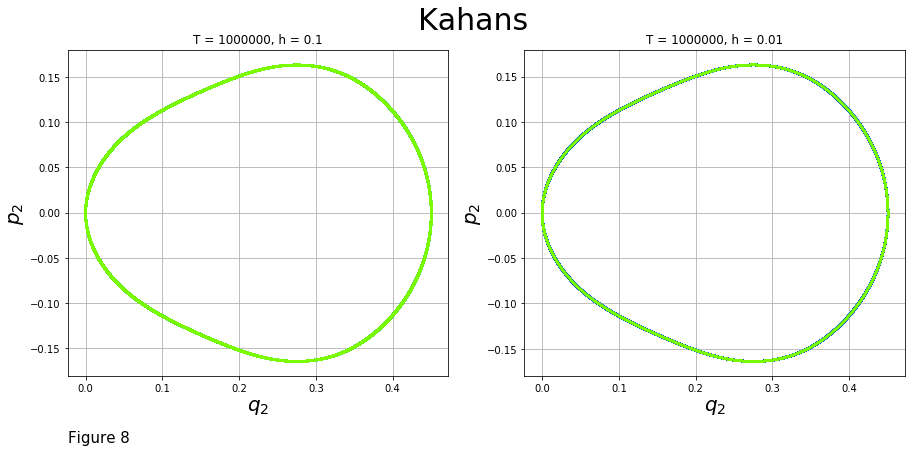

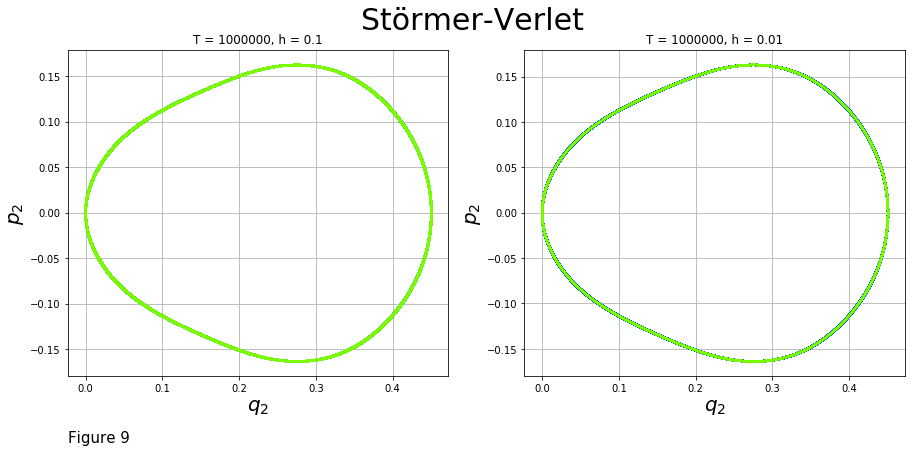

In [28]:
# Function that plots Poincaré cuts. 
def Plot_Poincaré(method, t_0, T_1, T_2, h_1, h_2, y_0, title, textnr):
    fig, (fig1,fig2) = plt.subplots(1,2, figsize = (15,6)) 

    # Gets the q_2 and p_2 arrays for the two different stepsizes.
    q_2_array_1, p_2_array_1 = Poincaré(method, t_0, T_1, h_1, y_0)
    q_2_array_2, p_2_array_2 = Poincaré(method, t_0, T_2, h_2, y_0)
    
    figtext = ["Figure 6", "Figure 7", "Figure 8", "Figure 9"]

    # Plots the Poincaré-cuts for the two different stepsizes and changes the colour of the plot
    # for every fifth part of the array. The rest is just to make the plots look nice.
    l = len(q_2_array_1)
    fig1.plot(q_2_array_1[0:l//5],p_2_array_1[0:l//5], '.',color = "blue", markersize = 2)
    fig1.plot(q_2_array_1[l//5:2*l//5],p_2_array_1[l//5:2*l//5],  '.', color= "dodgerblue", markersize = 2)
    fig1.plot(q_2_array_1[2*l//5:3*l//5],p_2_array_1[2*l//5:3*l//5], '.', color = "mediumspringgreen", markersize = 2)
    fig1.plot(q_2_array_1[3*l//5:4*l//5],p_2_array_1[3*l//5:4*l//5], '.', color = "limegreen", markersize = 2)
    fig1.plot(q_2_array_1[4*l//5:l],p_2_array_1[4*l//5:l], '.', color = "lawngreen", markersize = 2)
    fig1.title.set_text("T = " + str(int(T_1)) + ", h = " + str(h_1) )
    fig1.set_xlabel("$q_2$", size = 20)
    fig1.set_ylabel("$p_2$", size = 20)
    plt.figtext(0.125, 0.00, figtext[textnr], fontsize = 15, va = "top", ha = "left")

    fig1.grid()
    l = len(q_2_array_2)
    fig2.plot(q_2_array_2[0:l//5],p_2_array_2[0:l//5], '.',color = "blue", markersize = 3)
    fig2.plot(q_2_array_2[l//5:2*l//5],p_2_array_2[l//5:2*l//5],  '.', color= "dodgerblue", markersize = 2)
    fig2.plot(q_2_array_2[2*l//5:3*l//5],p_2_array_2[2*l//5:3*l//5], '.', color = "mediumspringgreen", markersize = 1)
    fig2.plot(q_2_array_2[3*l//5:4*l//5],p_2_array_2[3*l//5:4*l//5], '.', color = "limegreen", markersize = 1)
    fig2.plot(q_2_array_2[4*l//5:l],p_2_array_2[4*l//5:l], '.', color = "lawngreen", markersize = 1)
    fig2.title.set_text("T = " + str(int(T_2)) + ", h = " + str(h_2) )
    fig2.set_xlabel("$q_2$", size = 20)
    fig2.set_ylabel("$p_2$", size = 20)
    fig2.grid()

    fig.suptitle(title, size = 30)
    plt.show()

# Plots all poincaré cuts.
Plot_Poincaré(Shampine_Bogacki, 0, 1e6,1e6, 0.1, 0.01, y_0, "Shampine-Bogacki", 0)
Plot_Poincaré(Runge_Kutta, 0, 1e6, 1e6, 0.1, 0.01, y_0, "Runge-Kutta", 1)
Plot_Poincaré(Kahans, 0, 1e6, 1e6, 0.1, 0.01, y_0, "Kahans", 2)
Plot_Poincaré(Störmer_Verlet, 0, 1e6, 1e6, 0.1, 0.01, y_0 ,"Störmer-Verlet", 3)


From the Poincaré-cuts for the different methods we can see how the dynamic of the system transpires. We see that with h = 0.01, all plots are very similar to the plot on page 7 from the handout. We can therefore conclude that any deviation from this curve comes from the error in the corresponding method, as we calculated in Problem 2. 

If we do like Michel Hénon and Carl Heiles and interpret our model as the dynamics of a star it is easier to see the physical effect of the error as the system loosing energy. The trajectory of the star will then approach origo if it loses energy or stay in the same trajectory if the energy is preserved.

In Shampine-Bogacki we see that for h = 0.1, the system loses energy rapidly and aproaches origo. For h = 0.01, the system seems not to lose energy, but we can see a small line on the right side of the red line, which indicates a small energy loss.

In Runge-Kutta, with h = 0.1, the system also lose a significant amount of energy, only a lot slower. For h = 0.01, it is hard to see any deviation from the initial cut.

For Kahans and Störmer-Verlet, the system does not lose any energy for both of the stepsizes. The only difference we see between the two corresponding plots, is that both curves for h = 0.1 is thicker then that of h = 0.01. This is coherent with what we see in Problem 2, where the error decreases with an order of 100 if the steplength is shortened with a factor of 10 for these methods. A lower error will then result in a narrower graph in the Poincaré-Cuts.

As for the result of the Poincaré-Cuts it points to an interesting discovery within orbital dynamics and the intregrals of motion $[6]$. From orbital dynamics we have two classical integral of motion,  angular momentum $J$ and energy $E$. If these were the only two integral of motion we would expect each orbit to cross the surface of section($q_1 = 0 $) anywhere within some energetically permitted region. Instead we get a distinct contour (a line) on our plane. According to $[6]$, these lines are level surfaces of a mysterious third integral. A thrid integral mean the orbit is a combination of three periodic motions and can be reperesented as a path on an invariant 3-torus $[10]$. 
 




# Conclusion

In Problem 1 we estimated the rate of convergence for the four methods and found the estimated ROC of Shampine-Bogaci to be 2.9947, Runge-Kutta to be 4.0286, Kahans to be 1.9984 and Störmer-Verlet to be 2.0019. These results are coherent with the orders given in the handout and we have therefore verified the ROC for all four methods.


In Problem 2 we saw that the four methods are not all able to conserve energy at the same rate. Firstly, Shampine-Bogacki and Runge-Kutta both have energy drift $[3]$ causing both of the methods to lose energy when being integrated through many timesteps, as we can see from the Poincaré cuts in Figure 6, 7, 8, and 9. After observing each methods energy preservation with different stepsizes, we have concluded that the Störmer-Verlet method is the most suitable and stable method for longer timesteps. This is because it preserves energy at the best rate because it preserves its own modified hamiltonian at a much better rate and the modified version appear to be better allinged with the original energy as seen in Figure 5. It is this that separates it from Kahans method. On the other hand, Runge-Kutta is surperior for smaller timesteps, and should therefor be used for smaller timesteps. 


The Poincaré cuts confirms our results from Problem 2. Both Shampine-Bogacki and Runge-Kutta will eventually lose some, if not all, of its energy. We have not been able to observe significant energy loss from Kahans and Störmer-Verlet, and can therefore conclude that these two methods are surperior to the others over a longer period of time. To conclude, Runge-Kuttas method is better and more accurate for smaller timescales, while Störmer-Verlet is the desired method for large timescales. 




# Sources


$[1]$  E Celledoni, D I McLaren, B Owren and G R W Quispel (2019)  <em>Geometric and integrability properties of Kahan's method: the preservation of certain quadratic integrals </em> found on the internet at: [link](https://iopscience.iop.org/article/10.1088/1751-8121/aafb1e/pdf)

$[2]$  E Hairer, C Lubich, G Wanner (2006) <em> Geometric Numerical
Integration
Structure-Preserving
Algorithms for Ordinary
Diff erential Equations
</em>, found at: [link](https://link.springer.com/content/pdf/10.1007%2F3-540-30666-8.pdf)

$[3]$  Unknown(2020) <em> Energy drift </em>, found on wikipedia: [link](https://en.wikipedia.org/wiki/Energy_drift)

$[4]$  Unknown(2021) <em> Invariant Measure </em> found on wikipedia: [link](https://en.wikipedia.org/wiki/Invariant_measure)


$[5]$  L Li,(2019) <em> Energy-preserving
numerical methods for
differential equations:
Linearly implicit methods
and Krylov subspace
methods
</em>, found at: [link ](https://ntnuopen.ntnu.no/ntnu-xmlui/bitstream/handle/11250/2627256/LuLi_PhD.pdf?sequence=1&isAllowed=y&fbclid=IwAR3Z4mIu9ViiFlzz3nCdjcISya2a0H7FreIPL3RMGMVNMbvQwOKTj0JD6fs)


$[6]$  Unknown author from University of Hawaii(unknown) <em> Chapter 7
Orbits, Integrals, and Chaos</em> found on the internet at: [link](https://www.ifa.hawaii.edu/~barnes/ast626_05/oic.pdf)

$[7]$ Unknown(2021) <em>Runge-Kutta methods </em>, found on wikipedia at:[link](https://en.wikipedia.org/wiki/Runge%E2%80%93Kutta_methods)

$[8]$ Handout, "TMA4320 - Prosjekt 3 - 2021".

$[9]$ Bogacki, Przemysław; Shampine, Lawrence F. (1989), "A 3(2) pair of Runge–Kutta formulas", Applied Mathematics Letters, 2 (4): [link](321–325, doi:10.1016/0893-9659(89 90079-7)

$[10]$Unknown(2021) <em >Three-torus </em> , found on wikipedia at: [link] (https://en.wikipedia.org/wiki/Three-torus)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=29391064-d611-47dd-bd32-3cf2111b8f40' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>